In [1]:
import numpy as np
import sympy
import cirq
import tensorflow as tf
import tensorflow_quantum as tfq
import matplotlib.pyplot as plt

In [15]:
qubits = cirq.GridQubit.rect(1, 3)
circuit = cirq.Circuit()
symbols=[]
for k in range(3):
    circuit += cirq.I.on(qubits[k])    
for k in range(2):
    sy=sympy.Symbol(str(k))
    symbols.append(str(k))
    circuit += cirq.ry(sy)(qubits[k])


In [16]:
circuit

(0, 0): ───I───Ry(0)───

(0, 1): ───I───Ry(1)───

(0, 2): ───I───────────

In [17]:
ops = tfq.convert_to_tensor([[cirq.Z(qubits[2])]])

In [18]:
circuit_inputs = tf.keras.Input(shape=(), dtype=tf.dtypes.string)
expectation = tfq.layers.Expectation()(
        circuit_inputs,
        symbol_names = symbols,
        operators = ops
        )

In [19]:
model = tf.keras.Model(inputs = circuit_inputs, outputs=expectation)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss=tf.keras.losses.mean_squared_error)

In [20]:
model(tfq.convert_to_tensor([circuit]))

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.9999999]], dtype=float32)>

In [21]:
desired_outputs = tf.ones((1,2))*.5

In [22]:
@tf.function
def step():
    with tf.GradientTape() as tape:
        tape.watch(model.trainable_variables)
        preds = model(tfq.convert_to_tensor([circuit]))
        loss = model.loss(desired_outputs, preds)
        grads = tape.gradient(loss, model.trainable_variables)
        model.optimizer.apply_gradients(zip(grads, model.trainable_variables))
        return loss
    
#@tf.function
def step1():
    with tf.GradientTape() as tape:
        tape.watch(model.trainable_variables)
        preds = model(tfq.convert_to_tensor([circuit]))
        loss = model.loss(desired_outputs, preds)
        grads = tape.gradient(loss, model.trainable_variables)
        model.optimizer.apply_gradients(zip(grads, model.trainable_variables))
        return loss

In [24]:
ll = []
for k in range(1000):
    ll.append(step().numpy()[0])

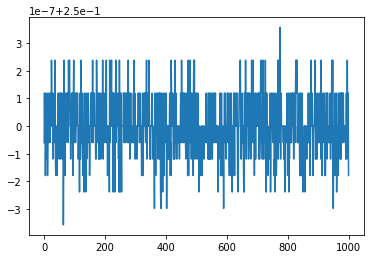

In [25]:
plt.plot(ll)

In [26]:
resolver = {k: v for k, v in zip(symbols, model.get_weights()[0])}
simulator = cirq.Simulator()
simulator.simulate(cirq.resolve_parameters(circuit,resolver))

measurements: (no measurements)
output vector: -0.364|000⟩ - 0.094|010⟩ + 0.897|100⟩ + 0.232|110⟩

In [27]:
la = tfq.convert_to_tensor([cirq.resolve_parameters(circuit,resolver)])
tfq.layers.Expectation()(la, operators= ops)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[1.]], dtype=float32)>